# Get started with Flower

Welcome to the Flower federated learning tutorial!

In this notebook, we'll build a federated learning system using Flower and PyTorch. In part 1, we use PyTorch for the model training pipeline and data loading. In part 2, we continue to federate the PyTorch-based pipeline using Flower.

> [Star Flower on GitHub](https://github.com/adap/flower) ⭐️ and join the Flower community on Slack to connect, ask questions, and get help: [Join Slack](https://flower.dev/join-slack) 🌼 We'd love to hear from you in the `#introductions` channel! And if anything is unclear, head over to the `#questions` channel.

Let's get stated!

## Step 0: Preparation

Before we begin with any actual code, let's make sure that we have everything we need.

### Installing dependencies

Next, we install the necessary packages for PyTorch (`torch` and `torchvision`) and Flower (`flwr`):

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [31]:
!pip install -q flwr[simulation] torch torchvision

In [78]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.0.1+cu118 and Flower 1.5.0


It is possible to switch to a runtime that has GPU acceleration enabled (on Google Colab: `Runtime > Change runtime type > Hardware acclerator: GPU > Save`). Note, however, that Google Colab is not always able to offer GPU acceleration. If you see an error related to GPU availability in one of the following sections, consider switching back to CPU-based execution by setting `DEVICE = torch.device("cpu")`. If the runtime has GPU acceleration enabled, you should see the output `Training on cuda`, otherwise it'll say `Training on cpu`.


### Loading the data

Federated learning can be applied to many different types of tasks across different domains. In this tutorial, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. CIFAR-10 can be used to train image classifiers that distinguish between images from ten different classes:

In [79]:
CLASSES = classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

We simulate having multiple datasets from multiple organizations (also called the "cross-silo" setting in federated learning) by splitting the original CIFAR-10 dataset into multiple partitions. Each partition will represent the data from a single organization. We're doing this purely for experimentation purposes, in the real world there's no need for data splitting because each organization already has their own data (so the data is naturally partitioned).

Each organization will act as a client in the federated learning system. So having ten organizations participate in a federation means having ten clients connected to the federated learning server:



Let's now load the CIFAR-10 training and test set, partition them into ten smaller datasets (each split into training and validation set), and wrap the resulting partitions by creating a PyTorch `DataLoader` for each of them:

In [80]:
NUM_CLIENTS = 4
BATCH_SIZE = batch_size = 32
ngpu = 1
image_size = 32
dataroot1 = "/home/ubuntu/Datasets/dg5/svhn"
dataroot2 = "/home/ubuntu/Datasets/dg5/mnist_m"
dataroot3 = "/home/ubuntu/Datasets/dg5/usps"
dataroot4 = "/home/ubuntu/Datasets/dg5/mnist"
dataroot_test = "/home/ubuntu/Datasets/dg5/syn"

def load_datasets():
    # transform SYN,svhn,usps,mm,mn to 32x32 (train and test)

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset1 = torchvision.datasets.ImageFolder(root=dataroot1, transform=transform)
    trainset2 = torchvision.datasets.ImageFolder(root=dataroot2, transform=transform)
    trainset3 = torchvision.datasets.ImageFolder(root=dataroot3, transform=transform)
    trainset4 = torchvision.datasets.ImageFolder(root=dataroot4, transform=transform)

    testset = torchvision.datasets.ImageFolder(root=dataroot_test, transform=transform)

    # Split training set into 4 partitions to simulate the individual dataset
    datasets = [trainset1,trainset2,trainset3,trainset4]

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

We now have a list of ten training sets and ten validation sets (`trainloaders` and `valloaders`) representing the data of ten different organizations. Each `trainloader`/`valloader` pair contains 4500 training examples and 500 validation examples. There's also a single `testloader` (we did not split the test set). Again, this is only necessary for building research or educational systems, actual federated learning systems have their data naturally distributed across multiple partitions.

Let's take a look at the first batch of images and labels in the first training set (i.e., `trainloaders[0]`) before we move on:

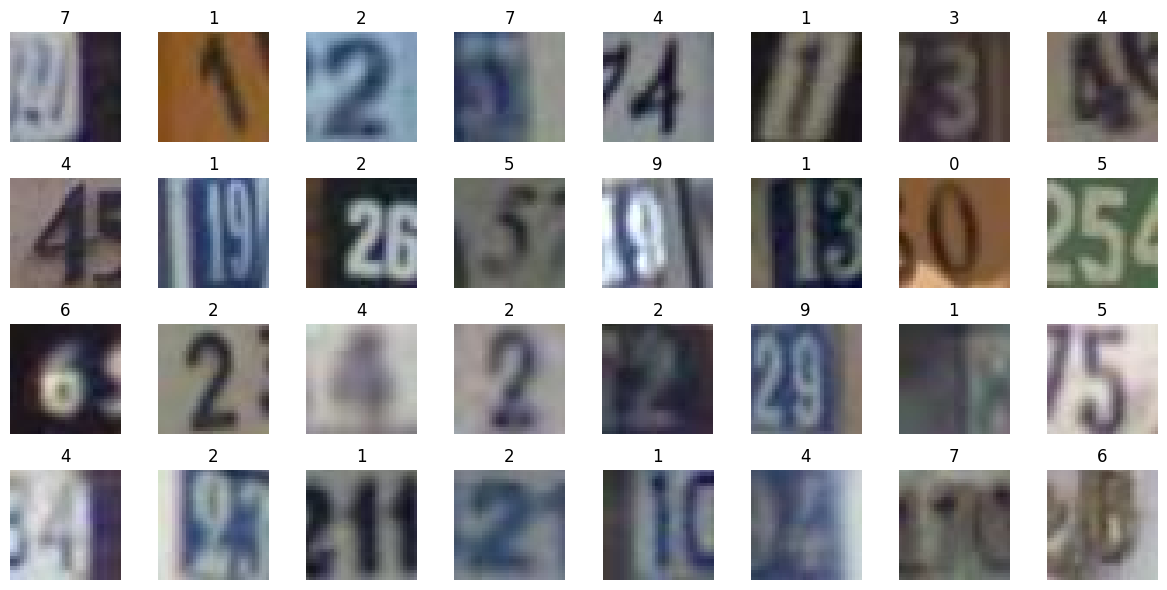

In [82]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

The output above shows a random batch of images from the first `trainloader` in our list of ten `trainloaders`. It also prints the labels associated with each image (i.e., one of the ten possible labels we've seen above). If you run the cell again, you should see another batch of images.

Next, we're going to use PyTorch to define a simple convolutional neural network. This introduction assumes basic familiarity with PyTorch, so it doesn't cover the PyTorch-related aspects in full detail. If you want to dive deeper into PyTorch, we recommend [*DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ*](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).


### Defining the model

We use the simple CNN described in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network):

In [83]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [84]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Training the simple CNN on our CIFAR-10 split for 5 epochs should result in a test set accuracy of about 41%, which is not good, but at the same time, it doesn't really matter for the purposes of this tutorial. The intent was just to show a simplistic centralized training pipeline that sets the stage for what comes next - federated learning!

### Implementing a Flower client

With that out of the way, let's move on to the interesting part. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

* `get_parameters`: Return the current local model parameters
* `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
* `evaluate`: Receive model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use the previously defined PyTorch components for model training and evaluation. Let's see a simple Flower client implementation that brings everything together:

In [85]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):

        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        # Use values provided by the config
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader)

def fit_config(server_round: int):
    """Return training configuration dict for each round.
    Perform 4 rounds of training with 30 local epoch.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning，just display.
        "local_epochs": 30,  #######
    }
    return config

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Using the Virtual Client Engine

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use, so they should not keep any local state). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for different clients, as can be seen below:

In [86]:
# The `evaluate` function will be by Flower called after every round
def generalize(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = Net().to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side unseen generalization loss {loss} / generalization accuracy {accuracy}")
    return loss, {"generalization accuracy": accuracy}

In [87]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

# ######Change Aggregation Strategy here<-------------Fed-Avg, xxq-FedAvg, Fed-Prox, Fed-Yogi....
strategy = fl.server.strategy.FedYogi(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1,  # Sample 100% of available clients for evaluation
    min_fit_clients=4,  # Never sample less than 4 clients for training
    min_evaluate_clients=4,  # Never sample less than 4 clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all 4 clients are available
    initial_parameters=fl.common.ndarrays_to_parameters(params),## initialize parameters
    evaluate_fn=generalize,  # Pass the generalization function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1, "num_cpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=6),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-12 22:09:40,351 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=6, round_timeout=None)
2023-09-12 22:09:45,322	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-12 22:09:46,225 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 8306407835.0, 'object_store_memory': 4153203916.0, 'GPU': 1.0, 'node:10.68.107.147': 1.0, 'node:__internal_head__': 1.0, 'accelerator_type:A30': 1.0, 'CPU': 4.0}
INFO flwr 2023-09-12 22:09:46,227 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 2023-09-12 22:09:46,243 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-09-12 22:09:46,246 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-12 22:09:46,247 | server.py:272 | Using initial parameters provided by strategy
INFO flwr 2023-09-12 22:09:46,249 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-12 22:

Server-side unseen generalization loss 0.07209184746082678 / generalization accuracy 0.09753590325018896
(DefaultActor pid=2610752) [Client 3] fit, config: {'server_round': 1, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.005539178382605314, accuracy 0.9433123893498108
(DefaultActor pid=2610752) [Client 2] fit, config: {'server_round': 1, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.018995849415659904, accuracy 0.7980663321502875
(DefaultActor pid=2610752) [Client 0] fit, config: {'server_round': 1, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.02504875510931015, accuracy 0.750213404083516
(DefaultActor pid=2610752) [Client 1] fit, config: {'server_round': 1, 'local_epochs': 30}


DEBUG flwr 2023-09-12 22:11:17,930 | server.py:236 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-12 22:11:17,945 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=2610752) Epoch 1: train loss 0.018780777230858803, accuracy 0.8091783247127434


INFO flwr 2023-09-12 22:11:28,357 | server.py:125 | fit progress: (1, 0.0719431604225349, {'generalization accuracy': 0.1217838246409675}, 91.78604796202853)
DEBUG flwr 2023-09-12 22:11:28,359 | server.py:173 | evaluate_round 1: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.0719431604225349 / generalization accuracy 0.1217838246409675
(DefaultActor pid=2610752) [Client 2] evaluate, config: {}
(DefaultActor pid=2610752) [Client 1] evaluate, config: {}
(DefaultActor pid=2610752) [Client 3] evaluate, config: {}
(DefaultActor pid=2610752) [Client 0] evaluate, config: {}


DEBUG flwr 2023-09-12 22:11:37,873 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-12 22:11:37,874 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-12 22:11:37,877 | server.py:222 | fit_round 2: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2610752) [Client 1] fit, config: {'server_round': 2, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.016488341614603996, accuracy 0.8353698753775124
(DefaultActor pid=2610752) [Client 3] fit, config: {'server_round': 2, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.004454596433788538, accuracy 0.9561564897420766
(DefaultActor pid=2610752) [Client 2] fit, config: {'server_round': 2, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.014607032760977745, accuracy 0.8588912005874434
(DefaultActor pid=2610752) [Client 0] fit, config: {'server_round': 2, 'local_epochs': 30}


DEBUG flwr 2023-09-12 22:12:54,777 | server.py:236 | fit_round 2 received 4 results and 0 failures


(DefaultActor pid=2610752) Epoch 1: train loss 0.020926084369421005, accuracy 0.7965855346637444


INFO flwr 2023-09-12 22:13:05,118 | server.py:125 | fit progress: (2, 0.07049286368752823, {'generalization accuracy': 0.22645502645502646}, 188.54728684341535)
DEBUG flwr 2023-09-12 22:13:05,119 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.07049286368752823 / generalization accuracy 0.22645502645502646
(DefaultActor pid=2610752) [Client 0] evaluate, config: {}
(DefaultActor pid=2610752) [Client 2] evaluate, config: {}
(DefaultActor pid=2610752) [Client 3] evaluate, config: {}
(DefaultActor pid=2610752) [Client 1] evaluate, config: {}


DEBUG flwr 2023-09-12 22:13:14,243 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-12 22:13:14,244 | server.py:222 | fit_round 3: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2610752) [Client 0] fit, config: {'server_round': 3, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.018542861565947533, accuracy 0.823578267389549
(DefaultActor pid=2610752) [Client 1] fit, config: {'server_round': 3, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.015164248645305634, accuracy 0.8506265838164335
(DefaultActor pid=2610752) [Client 2] fit, config: {'server_round': 3, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.009949884377419949, accuracy 0.9076000489536165
(DefaultActor pid=2610752) [Client 3] fit, config: {'server_round': 3, 'local_epochs': 30}


DEBUG flwr 2023-09-12 22:14:33,220 | server.py:236 | fit_round 3 received 4 results and 0 failures


(DefaultActor pid=2610752) Epoch 1: train loss 0.003501070663332939, accuracy 0.9669004061512827


INFO flwr 2023-09-12 22:14:44,192 | server.py:125 | fit progress: (3, 0.06350152820146003, {'generalization accuracy': 0.43331821617535904}, 287.62149329530075)
DEBUG flwr 2023-09-12 22:14:44,194 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.06350152820146003 / generalization accuracy 0.43331821617535904
(DefaultActor pid=2610752) [Client 0] evaluate, config: {}
(DefaultActor pid=2610752) [Client 1] evaluate, config: {}
(DefaultActor pid=2610752) [Client 2] evaluate, config: {}
(DefaultActor pid=2610752) [Client 3] evaluate, config: {}


DEBUG flwr 2023-09-12 22:14:53,332 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-12 22:14:53,333 | server.py:222 | fit_round 4: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2610752) [Client 0] fit, config: {'server_round': 4, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.017151784151792526, accuracy 0.8376860076133349
(DefaultActor pid=2610752) [Client 3] fit, config: {'server_round': 4, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.0027951374650001526, accuracy 0.9720727600930329
(DefaultActor pid=2610752) [Client 1] fit, config: {'server_round': 4, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.013841783627867699, accuracy 0.8669247058006735
(DefaultActor pid=2610752) [Client 2] fit, config: {'server_round': 4, 'local_epochs': 30}


DEBUG flwr 2023-09-12 22:16:12,266 | server.py:236 | fit_round 4 received 4 results and 0 failures


(DefaultActor pid=2610752) Epoch 1: train loss 0.006698914337903261, accuracy 0.9430914208787174


INFO flwr 2023-09-12 22:16:22,537 | server.py:125 | fit progress: (4, 0.04699891007856627, {'generalization accuracy': 0.5816477702191988}, 385.96575719397515)
DEBUG flwr 2023-09-12 22:16:22,538 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.04699891007856627 / generalization accuracy 0.5816477702191988
(DefaultActor pid=2610752) [Client 1] evaluate, config: {}
(DefaultActor pid=2610752) [Client 3] evaluate, config: {}
(DefaultActor pid=2610752) [Client 0] evaluate, config: {}
(DefaultActor pid=2610752) [Client 2] evaluate, config: {}


DEBUG flwr 2023-09-12 22:16:32,525 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-12 22:16:32,526 | server.py:222 | fit_round 5: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2610752) [Client 2] fit, config: {'server_round': 5, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.004662841092795134, accuracy 0.9572879696487578
(DefaultActor pid=2610752) [Client 1] fit, config: {'server_round': 5, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.012820059433579445, accuracy 0.8738153920921998
(DefaultActor pid=2610752) [Client 0] fit, config: {'server_round': 5, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.01584034599363804, accuracy 0.8516437882108663
(DefaultActor pid=2610752) [Client 3] fit, config: {'server_round': 5, 'local_epochs': 30}


DEBUG flwr 2023-09-12 22:17:55,121 | server.py:236 | fit_round 5 received 4 results and 0 failures


(DefaultActor pid=2610752) Epoch 1: train loss 0.0023523541167378426, accuracy 0.9763599125212622


INFO flwr 2023-09-12 22:18:05,103 | server.py:125 | fit progress: (5, 0.03246163817174671, {'generalization accuracy': 0.67286470143613}, 488.53215383924544)
DEBUG flwr 2023-09-12 22:18:05,105 | server.py:173 | evaluate_round 5: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.03246163817174671 / generalization accuracy 0.67286470143613
(DefaultActor pid=2610752) [Client 3] evaluate, config: {}
(DefaultActor pid=2610752) [Client 1] evaluate, config: {}
(DefaultActor pid=2610752) [Client 0] evaluate, config: {}
(DefaultActor pid=2610752) [Client 2] evaluate, config: {}


DEBUG flwr 2023-09-12 22:18:13,198 | server.py:187 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-12 22:18:13,199 | server.py:222 | fit_round 6: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2610752) [Client 2] fit, config: {'server_round': 6, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.003930191975086927, accuracy 0.9631624036225677
(DefaultActor pid=2610752) [Client 1] fit, config: {'server_round': 6, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.011875840835273266, accuracy 0.880931717985212
(DefaultActor pid=2610752) [Client 3] fit, config: {'server_round': 6, 'local_epochs': 30}
(DefaultActor pid=2610752) Epoch 1: train loss 0.002139882417395711, accuracy 0.9786683792133857
(DefaultActor pid=2610752) [Client 0] fit, config: {'server_round': 6, 'local_epochs': 30}


DEBUG flwr 2023-09-12 22:19:41,353 | server.py:236 | fit_round 6 received 4 results and 0 failures


(DefaultActor pid=2610752) Epoch 1: train loss 0.0147117143496871, accuracy 0.861345022493944


INFO flwr 2023-09-12 22:19:52,522 | server.py:125 | fit progress: (6, 0.030342795641660602, {'generalization accuracy': 0.7275283446712019}, 595.9513605763204)
DEBUG flwr 2023-09-12 22:19:52,524 | server.py:173 | evaluate_round 6: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.030342795641660602 / generalization accuracy 0.7275283446712019
(DefaultActor pid=2610752) [Client 0] evaluate, config: {}
(DefaultActor pid=2610752) [Client 3] evaluate, config: {}
(DefaultActor pid=2610752) [Client 1] evaluate, config: {}
(DefaultActor pid=2610752) [Client 2] evaluate, config: {}


DEBUG flwr 2023-09-12 22:20:00,453 | server.py:187 | evaluate_round 6 received 4 results and 0 failures
INFO flwr 2023-09-12 22:20:00,454 | server.py:153 | FL finished in 603.883476014249
INFO flwr 2023-09-12 22:20:00,456 | app.py:225 | app_fit: losses_distributed [(1, 0.07214962801276961), (2, 0.07010837751458193), (3, 0.06202914787213159), (4, 0.04520352025658603), (5, 0.031047046657829744), (6, 0.025032240501016115)]
INFO flwr 2023-09-12 22:20:00,457 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-12 22:20:00,459 | app.py:227 | app_fit: metrics_distributed {}
INFO flwr 2023-09-12 22:20:00,460 | app.py:228 | app_fit: losses_centralized [(0, 0.07209184746082678), (1, 0.0719431604225349), (2, 0.07049286368752823), (3, 0.06350152820146003), (4, 0.04699891007856627), (5, 0.03246163817174671), (6, 0.030342795641660602)]
INFO flwr 2023-09-12 22:20:00,461 | app.py:229 | app_fit: metrics_centralized {'generalization accuracy': [(0, 0.09753590325018896), (1, 0.12178382464

History (loss, distributed):
	round 1: 0.07214962801276961
	round 2: 0.07010837751458193
	round 3: 0.06202914787213159
	round 4: 0.04520352025658603
	round 5: 0.031047046657829744
	round 6: 0.025032240501016115
History (loss, centralized):
	round 0: 0.07209184746082678
	round 1: 0.0719431604225349
	round 2: 0.07049286368752823
	round 3: 0.06350152820146003
	round 4: 0.04699891007856627
	round 5: 0.03246163817174671
	round 6: 0.030342795641660602
History (metrics, centralized):
{'generalization accuracy': [(0, 0.09753590325018896), (1, 0.1217838246409675), (2, 0.22645502645502646), (3, 0.43331821617535904), (4, 0.5816477702191988), (5, 0.67286470143613), (6, 0.7275283446712019)]}

In [ ]:
====================================================================================end

In [18]:
# Create an instance of the model and get the parameters
params = get_parameters(Net())

# ######Change Aggregation Strategy here<-------------Fed-Avg, xxq-FedAvg, Fed-Prox, Fed-Yogi....
strategy = fl.server.strategy.FedProx(
    proximal_mu =1,
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1,  # Sample 100% of available clients for evaluation
    min_fit_clients=4,  # Never sample less than 4 clients for training
    min_evaluate_clients=4,  # Never sample less than 4 clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all 4 clients are available
    initial_parameters=fl.common.ndarrays_to_parameters(params),## initialize parameters
    evaluate_fn=generalize,  # Pass the generalization function
    on_fit_config_fn=fit_config,  # Pass the fit_config function
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1, "num_cpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=4),  # Just three rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-12 20:21:07,318 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=4, round_timeout=None)
2023-09-12 20:21:12,698	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-12 20:21:13,579 | app.py:210 | Flower VCE: Ray initialized with resources: {'node:10.68.107.147': 1.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'object_store_memory': 4232332492.0, 'memory': 8464664987.0, 'CPU': 4.0, 'accelerator_type:A30': 1.0}
INFO flwr 2023-09-12 20:21:13,581 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_gpus': 1, 'num_cpus': 1}
INFO flwr 2023-09-12 20:21:13,595 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO flwr 2023-09-12 20:21:13,597 | server.py:89 | Initializing global parameters
INFO flwr 2023-09-12 20:21:13,598 | server.py:272 | Using initial parameters provided by strategy
INFO flwr 2023-09-12 20:21:13,599 | server.py:91 | Evaluating initial parameters
INFO flwr 2023-09-12 20:

Server-side unseen generalization loss 0.07199699136974905 / generalization accuracy 0.11969069749277512
(DefaultActor pid=2601356) [Client 0] fit, config: {'server_round': 1, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.02108178287744522, accuracy 0.7829212577264176
(DefaultActor pid=2601356) [Client 3] fit, config: {'server_round': 1, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.017495084553956985, accuracy 0.8247127434304162
(DefaultActor pid=2601356) [Client 2] fit, config: {'server_round': 1, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.02423943020403385, accuracy 0.7602030222632368
(DefaultActor pid=2601356) [Client 1] fit, config: {'server_round': 1, 'local_epochs': 30, 'proximal_mu': 1}


DEBUG flwr 2023-09-12 20:22:39,194 | server.py:236 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-12 20:22:39,204 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=2601356) Epoch 1: train loss 0.01697658561170101, accuracy 0.8279280381838209


INFO flwr 2023-09-12 20:22:57,724 | server.py:125 | fit progress: (1, 0.03223054020349229, {'generalization accuracy': 0.6552839178317582}, 85.02661840897053)
DEBUG flwr 2023-09-12 20:22:57,725 | server.py:173 | evaluate_round 1: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.03223054020349229 / generalization accuracy 0.6552839178317582
(DefaultActor pid=2601356) [Client 1] evaluate, config: {}
(DefaultActor pid=2601356) [Client 2] evaluate, config: {}
(DefaultActor pid=2601356) [Client 3] evaluate, config: {}
(DefaultActor pid=2601356) [Client 0] evaluate, config: {}


DEBUG flwr 2023-09-12 20:23:05,530 | server.py:187 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-12 20:23:05,531 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-12 20:23:05,532 | server.py:222 | fit_round 2: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2601356) [Client 3] fit, config: {'server_round': 2, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.012584056705236435, accuracy 0.8744402402193912
(DefaultActor pid=2601356) [Client 1] fit, config: {'server_round': 2, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.0046963440254330635, accuracy 0.954473136702974
(DefaultActor pid=2601356) [Client 0] fit, config: {'server_round': 2, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.01121358573436737, accuracy 0.888873958613276
(DefaultActor pid=2601356) [Client 2] fit, config: {'server_round': 2, 'local_epochs': 30, 'proximal_mu': 1}


DEBUG flwr 2023-09-12 20:24:22,717 | server.py:236 | fit_round 2 received 4 results and 0 failures


(DefaultActor pid=2601356) Epoch 1: train loss 0.015383865684270859, accuracy 0.8554965970700196


INFO flwr 2023-09-12 20:24:41,002 | server.py:125 | fit progress: (2, 0.01671819705398189, {'generalization accuracy': 0.8486604702022963}, 188.30448017828166)
DEBUG flwr 2023-09-12 20:24:41,003 | server.py:173 | evaluate_round 2: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.01671819705398189 / generalization accuracy 0.8486604702022963
(DefaultActor pid=2601356) [Client 1] evaluate, config: {}
(DefaultActor pid=2601356) [Client 2] evaluate, config: {}
(DefaultActor pid=2601356) [Client 3] evaluate, config: {}
(DefaultActor pid=2601356) [Client 0] evaluate, config: {}


DEBUG flwr 2023-09-12 20:24:47,749 | server.py:187 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-12 20:24:47,751 | server.py:222 | fit_round 3: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2601356) [Client 0] fit, config: {'server_round': 3, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.008572492748498917, accuracy 0.9151101854340231
(DefaultActor pid=2601356) [Client 3] fit, config: {'server_round': 3, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.011007586494088173, accuracy 0.8866594924844656
(DefaultActor pid=2601356) [Client 2] fit, config: {'server_round': 3, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.013116925023496151, accuracy 0.8749221363479064
(DefaultActor pid=2601356) [Client 1] fit, config: {'server_round': 3, 'local_epochs': 30, 'proximal_mu': 1}


DEBUG flwr 2023-09-12 20:25:58,075 | server.py:236 | fit_round 3 received 4 results and 0 failures


(DefaultActor pid=2601356) Epoch 1: train loss 0.0038015020545572042, accuracy 0.9632847876636886


INFO flwr 2023-09-12 20:26:18,162 | server.py:125 | fit progress: (3, 0.010784263554537855, {'generalization accuracy': 0.8963836600796689}, 285.4649404939264)
DEBUG flwr 2023-09-12 20:26:18,164 | server.py:173 | evaluate_round 3: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.010784263554537855 / generalization accuracy 0.8963836600796689
(DefaultActor pid=2601356) [Client 3] evaluate, config: {}
(DefaultActor pid=2601356) [Client 0] evaluate, config: {}
(DefaultActor pid=2601356) [Client 2] evaluate, config: {}
(DefaultActor pid=2601356) [Client 1] evaluate, config: {}


DEBUG flwr 2023-09-12 20:26:25,964 | server.py:187 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-12 20:26:25,966 | server.py:222 | fit_round 4: strategy sampled 4 clients (out of 4)


(DefaultActor pid=2601356) [Client 3] fit, config: {'server_round': 4, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.010318643413484097, accuracy 0.8932898253896623
(DefaultActor pid=2601356) [Client 0] fit, config: {'server_round': 4, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.007410625461488962, accuracy 0.9255912389142703
(DefaultActor pid=2601356) [Client 2] fit, config: {'server_round': 4, 'local_epochs': 30, 'proximal_mu': 1}
(DefaultActor pid=2601356) Epoch 1: train loss 0.01187007687985897, accuracy 0.8859960779790057
(DefaultActor pid=2601356) [Client 1] fit, config: {'server_round': 4, 'local_epochs': 30, 'proximal_mu': 1}


DEBUG flwr 2023-09-12 20:27:33,424 | server.py:236 | fit_round 4 received 4 results and 0 failures


(DefaultActor pid=2601356) Epoch 1: train loss 0.0035067638382315636, accuracy 0.9653653163627463


INFO flwr 2023-09-12 20:27:53,297 | server.py:125 | fit progress: (4, 0.011188536295775335, {'generalization accuracy': 0.899914082636882}, 380.5993794440292)
DEBUG flwr 2023-09-12 20:27:53,299 | server.py:173 | evaluate_round 4: strategy sampled 4 clients (out of 4)


Server-side unseen generalization loss 0.011188536295775335 / generalization accuracy 0.899914082636882
(DefaultActor pid=2601356) [Client 3] evaluate, config: {}
(DefaultActor pid=2601356) [Client 2] evaluate, config: {}
(DefaultActor pid=2601356) [Client 1] evaluate, config: {}
(DefaultActor pid=2601356) [Client 0] evaluate, config: {}


DEBUG flwr 2023-09-12 20:28:00,653 | server.py:187 | evaluate_round 4 received 4 results and 0 failures
INFO flwr 2023-09-12 20:28:00,654 | server.py:153 | FL finished in 387.9569833329879
INFO flwr 2023-09-12 20:28:00,655 | app.py:225 | app_fit: losses_distributed [(1, 0.04332482980836084), (2, 0.02200467162977423), (3, 0.0193803316517415), (4, 0.018186878687130696)]
INFO flwr 2023-09-12 20:28:00,656 | app.py:226 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-12 20:28:00,657 | app.py:227 | app_fit: metrics_distributed {}
INFO flwr 2023-09-12 20:28:00,658 | app.py:228 | app_fit: losses_centralized [(0, 0.07199699136974905), (1, 0.03223054020349229), (2, 0.01671819705398189), (3, 0.010784263554537855), (4, 0.011188536295775335)]
INFO flwr 2023-09-12 20:28:00,659 | app.py:229 | app_fit: metrics_centralized {'generalization accuracy': [(0, 0.11969069749277512), (1, 0.6552839178317582), (2, 0.8486604702022963), (3, 0.8963836600796689), (4, 0.899914082636882)]}


History (loss, distributed):
	round 1: 0.04332482980836084
	round 2: 0.02200467162977423
	round 3: 0.0193803316517415
	round 4: 0.018186878687130696
History (loss, centralized):
	round 0: 0.07199699136974905
	round 1: 0.03223054020349229
	round 2: 0.01671819705398189
	round 3: 0.010784263554537855
	round 4: 0.011188536295775335
History (metrics, centralized):
{'generalization accuracy': [(0, 0.11969069749277512), (1, 0.6552839178317582), (2, 0.8486604702022963), (3, 0.8963836600796689), (4, 0.899914082636882)]}

### Behind the scenes

So how does this work? How does Flower execute this simulation?

When we call `start_simulation`, we tell Flower that there are 10 clients (`num_clients=10`). Flower then goes ahead an asks the `FedAvg` strategy to select clients. `FedAvg` knows that it should select 100% of the available clients (`fraction_fit=1.0`), so it goes ahead and selects 10 random clients (i.e., 100% of 10).

Flower then asks the selected 10 clients to train the model. When the server receives the model parameter updates from the clients, it hands those updates over to the strategy (*FedAvg*) for aggregation. The strategy aggregates those updates and returns the new global model, which then gets used in the next round of federated learning.

### Where's the accuracy?

You may have noticed that all metrics except for `losses_distributed` are empty. Where did the `{"accuracy": float(accuracy)}` go?

Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

As users, we need to tell the framework how to handle/aggregate these custom metrics, and we do so by passing metric aggregation functions to the strategy. The strategy will then call these functions whenever it receives fit or evaluate metrics from clients. The two possible functions are `fit_metrics_aggregation_fn` and `evaluate_metrics_aggregation_fn`.

Let's create a simple weighted averaging function to aggregate the `accuracy` metric we return from `evaluate`:

In [32]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

The only thing left to do is to tell the strategy to call this function whenever it receives evaluation metric dictionaries from the clients:

In [33]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1,
    min_fit_clients=4,
    min_evaluate_clients=4,
    min_available_clients=4,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-09-10 13:50:38,118 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-09-10 13:50:43,439	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-09-10 13:50:45,114 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7754735616.0, 'object_store_memory': 3877367808.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7754735616.0, 'object_store_memory': 3877367808.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2023-09-10 13:50:45,125 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-09-10 13:50:45,132 | app.py:224 | Flower VCE: Resources for each Virtual Clie

History (loss, distributed):
	round 1: 0.0469954641252222
	round 2: 0.02206205269422551
	round 3: 0.019785900933225884
	round 4: 0.018084243839055655
	round 5: 0.016252841751602944
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.5494234743747302), (2, 0.7841117646651958), (3, 0.8020638801943873), (4, 0.8177082989301987), (5, 0.8371828244502929)]}

We now have a full system that performs federated training and federated evaluation. It uses the `weighted_average` function to aggregate custom evaluation metrics and calculates a single `accuracy` metric across all clients on the server side.

The other two categories of metrics (`losses_centralized` and `metrics_centralized`) are still empty because they only apply when centralized evaluation is being used. Part two of the Flower tutorial will cover centralized evaluation.

## Final remarks

Congratulations, you just trained a convolutional neural network, federated over 10 clients! With that, you understand the basics of federated learning with Flower. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just CIFAR-10 images classification), for example NLP with Hugging Face Transformers or speech with SpeechBrain.

In the next notebook, we're going to cover some more advanced concepts. Want to customize your strategy? Initialize parameters on the server side? Or evaluate the aggregated model on the server side? We'll cover all this and more in the next tutorial.

## Next steps

Before you continue, make sure to join the Flower community on Slack: [Join Slack](https://flower.dev/join-slack/)

There's a dedicated `#questions` channel if you need help, but we'd also love to hear who you are in `#introductions`!

The [Flower Federated Learning Tutorial - Part 2](https://flower.dev/docs/framework/tutorial-use-a-federated-learning-strategy-pytorch.html) goes into more depth about strategies and all the advanced things you can build with them.